In [7]:
import torch
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def plot_forward(net, conductivity=None, heat_source=None):

    x = np.arange(0, 2, 0.02)
    t = np.arange(0, 1, 0.02)
    ms_x, ms_t = np.meshgrid(x, t)
    x_all = np.ravel(ms_x).reshape(-1, 1)
    t_all = np.ravel(ms_t).reshape(-1, 1)
    pt_x = Variable(torch.from_numpy(x_all).float(), requires_grad=False).to(device)
    pt_t = Variable(torch.from_numpy(t_all).float(), requires_grad=False).to(device)

    if heat_source is not None:

      pt_u = heat_source(pt_x, pt_t)
      u = pt_u.data.cpu().numpy()
      ms_u = u.reshape(ms_x.shape)

      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')

      surf = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
      fig.colorbar(surf, shrink=0.4, aspect=5)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('heat source q(x,t)')
      plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    pt_u = net(pt_x, pt_t)
    u = pt_u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)

    surf = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.4, aspect=5)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('temperature u(x,t)')
    plt.show()

    if conductivity is not None:
      u = conductivity(Variable(torch.from_numpy(x).float()))

      plt.plot(x, u, '+')
      plt.xlabel('x')
      plt.ylabel('k')
      plt.title('conductivity k(x)')
      plt.show()

**Definition du probleme de transfert de chaleur**

In [9]:
class forward_problem:
  def __init__(self, net=None):
    # La variable net sera la fonction de regression qui approximera le champ de chaleur
    if net is not None:
      self.net = net

  def heat_source(self, x, t):
    # La valeur du terme source de chaleur q(x,t), ici nulle partout
    q = torch.zeros_like(x)
    return q

  def advection(self, x, t, u, beta, uref):
    # Calcul du terme d'advection : beta*(u - uref)
    q = beta * (u - uref)
    return q

  def conductivity(self, x):
    # Conductivité constante, ici choisie égale à 1
    k = torch.ones_like(x)
    return k

  def heat_capacity(self, x):
    # Chaleur spécifique constante égale à 1
    c = torch.ones_like(x)
    return c

  def ic(self, x):
    # Conditions initiales: u(x,0) = 0
    ic = torch.zeros_like(x)
    return ic

  def bc(self, x, t):
    # Conditions aux limites: u(0,t) = 1 - exp(-t/0.1) et u(2,t) = 0
    B = 1.0
    T_u = 0.1
    bc_val = torch.where(torch.abs(x - 0.0) < 1e-6, B * (1 - torch.exp(-t / T_u)),
              torch.where(torch.abs(x - 2.0) < 1e-6, torch.zeros_like(x), torch.zeros_like(x)))
    return bc_val

  def f(self, x, t):
    # Estimation : u = net(x,t)
    u = self.net(x, t)

    # Calcul du gradient de u par rapport à x
    u_x = torch.autograd.grad(
      u, x,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0]

    flux = -1.0 * self.conductivity(x) * u_x

    # Calcul de la dérivée de flux par rapport à x
    flux_x = torch.autograd.grad(
      flux, x,
      grad_outputs=torch.ones_like(flux),
      retain_graph=True,
      create_graph=True
    )[0]

    # Calcul de la dérivée de u par rapport au temps
    u_t = torch.autograd.grad(
      u, t,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0]

    c = self.heat_capacity(x)
    beta = 3.0
    uref = 0.0
    adv = self.advection(x, t, u, beta, uref)
    q = self.heat_source(x, t)

    # Residuel de l'équation de la chaleur: c*u_t + (d/dx flux) + advection - q = 0
    residual = c * u_t + flux_x + adv - q
    return residual

  # Residuel pour les conditions aux limites
  def f_bc(self, x, t):
    u = self.net(x, t)
    residual = u - self.bc(x, t)
    return residual

  # Residuel pour les conditions initiales
  def f_ic(self, x, t):
    u = self.net(x, t)
    residual = u - self.ic(x)
    return residual

  def solve(self, N_iter=1000):
    solve(self, N_iter)

  def plot_forward(self):
    plot_forward(self.net)


**La definition du reseau de neurones**

In [10]:
# Un reseau standard feed forward
# Le choix des paramètres reste toujours un problème ouvert
class FCN(torch.nn.Module):
    def __init__(self):
      super(FCN, self).__init__()
      self.hidden_layer1 = torch.nn.Linear(2, 100)
      self.hidden_layer2 = torch.nn.Linear(100, 10)
      self.output_layer = torch.nn.Linear(10, 1)

    def forward(self, x, t):
      inputs = torch.cat([x, t], axis=1)  # On concatène pour avoir une seule variable
      layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
      layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
      output = self.output_layer(layer2_out)  # Pour une régression, pas d'activation après la dernière couche
      return output


In [11]:
def solve(problem, N_iter=1000):

    net = problem.net

    mse_cost_function = torch.nn.MSELoss()  # Mean squared error
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-2, weight_decay=1.0e-100)

    # Echantillonnage aléatoire dans le domaine de x
    pt_x_collocation = Variable(torch.Tensor(100, 1).uniform_(0.0, 2.0), requires_grad=True).to(device)

    # Echantillonnage aléatoire dans le domaine de t
    pt_t_collocation = Variable(torch.Tensor(100, 1).uniform_(0.0, 1.0), requires_grad=True).to(device)

    # Echantillonnage aléatoire dans le domaine de x pour les conditions initiales
    pt_x_collocation_ic = Variable(torch.Tensor(100, 1).uniform_(0.0, 2.0), requires_grad=False).to(device)

    # t pour ic: pour conditions initiales, t = 0
    pt_t_collocation_ic = Variable(torch.zeros(100, 1), requires_grad=False).to(device)

    # Générer des x aléatoires pour les conditions aux bords : 50 points pour x=0 et 50 pour x=2
    pt_x_left = Variable(torch.zeros(50, 1), requires_grad=False).to(device)
    pt_x_right = Variable(2 * torch.ones(50, 1), requires_grad=False).to(device)
    pt_x_collocation_bc = torch.cat([pt_x_left, pt_x_right], dim=0)

    # Echantillonnage aléatoire dans le domaine de t pour les conditions aux bords
    pt_t_collocation_bc = Variable(torch.Tensor(100, 1).uniform_(0.0, 1.0), requires_grad=False).to(device)

    # Si l'echantillonnage est aléatoire, il faut le refaire à chaque itération
    randomise_colloc = 1
    for epoch in range(N_iter):
        optimizer.zero_grad()  # Remise à zéro des gradients

        # Loss basée sur la PDE
        if randomise_colloc == 1:
            pt_x_collocation = Variable(torch.Tensor(100, 1).uniform_(0.0, 2.0), requires_grad=True).to(device)
            pt_t_collocation = Variable(torch.Tensor(100, 1).uniform_(0.0, 1.0), requires_grad=True).to(device)
        f_out = problem.f(pt_x_collocation, pt_t_collocation)  # Sortie de f(x,t)
        pt_all_zeros = Variable(torch.zeros_like(f_out), requires_grad=False).to(device)
        mse_f = mse_cost_function(f_out, pt_all_zeros)

        # Loss pour les conditions initiales
        if randomise_colloc == 1:
            pt_x_collocation_ic = Variable(torch.Tensor(100, 1).uniform_(0.0, 2.0), requires_grad=False).to(device)
            pt_t_collocation_ic = Variable(torch.zeros(100, 1), requires_grad=False).to(device)
        f_out_ic = problem.f_ic(pt_x_collocation_ic, pt_t_collocation_ic)
        pt_all_zeros = Variable(torch.zeros_like(f_out_ic), requires_grad=False).to(device)
        mse_ic = mse_cost_function(f_out_ic, pt_all_zeros)

        # Loss pour les conditions aux bords
        if randomise_colloc == 1:
            pt_x_left = Variable(torch.zeros(50, 1), requires_grad=False).to(device)
            pt_x_right = Variable(2 * torch.ones(50, 1), requires_grad=False).to(device)
            pt_x_collocation_bc = torch.cat([pt_x_left, pt_x_right], dim=0)
            pt_t_collocation_bc = Variable(torch.Tensor(100, 1).uniform_(0.0, 1.0), requires_grad=False).to(device)
        f_out_bc = problem.f_bc(pt_x_collocation_bc, pt_t_collocation_bc)  # Sortie de f_bc(x,t)
        pt_all_zeros = Variable(torch.zeros_like(f_out_bc), requires_grad=False).to(device)
        mse_bc = mse_cost_function(f_out_bc, pt_all_zeros)

        # Loss globale
        loss = mse_f + mse_ic + mse_bc

        loss.backward()  # Calcul des gradients en backpropagation
        optimizer.step()  # Mise à jour des paramètres

        # Affichage de la loss
        if epoch <= 10 or epoch == 25 or epoch == 50 or epoch % 100 == 0:
          with torch.autograd.no_grad():
            print(epoch, "Training Loss:", loss.data)

        if epoch <= 10 or epoch == 25 or epoch == 50 or epoch == 100 or epoch == 250 or epoch % 500 == 0:
          problem.plot_forward()


**La procedure d'entrainement**

**Instantiation**

<IPython.core.display.Javascript object>

0 Training Loss: tensor(0.4701)


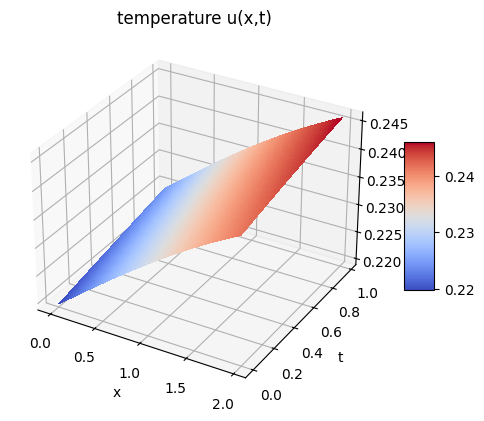

1 Training Loss: tensor(0.8434)


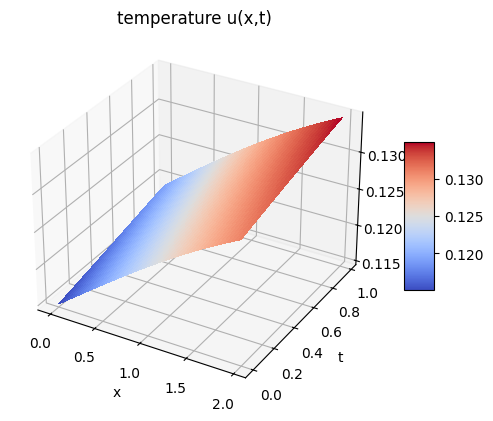

2 Training Loss: tensor(0.4945)


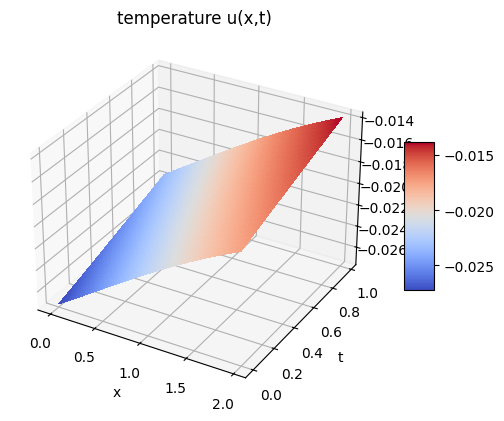

3 Training Loss: tensor(0.4804)


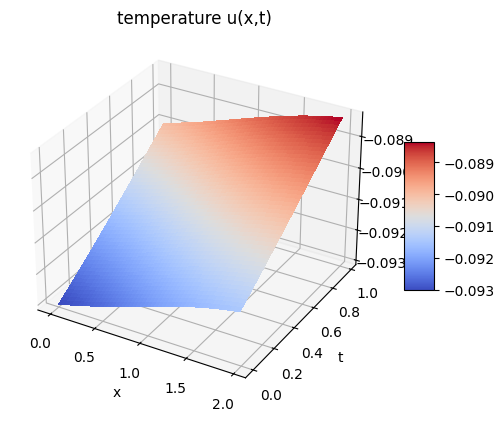

4 Training Loss: tensor(0.5730)


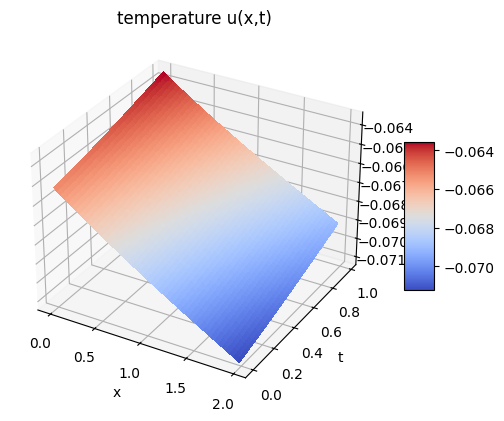

5 Training Loss: tensor(0.5257)


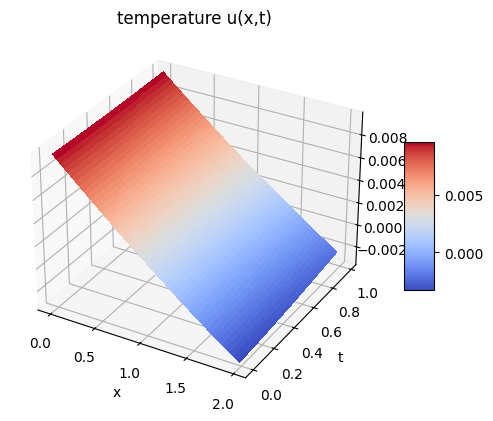

6 Training Loss: tensor(0.3968)


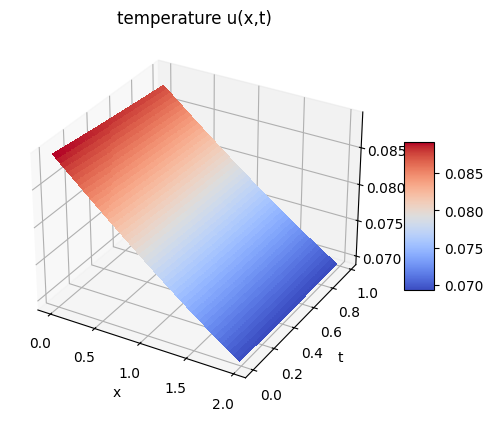

7 Training Loss: tensor(0.3951)


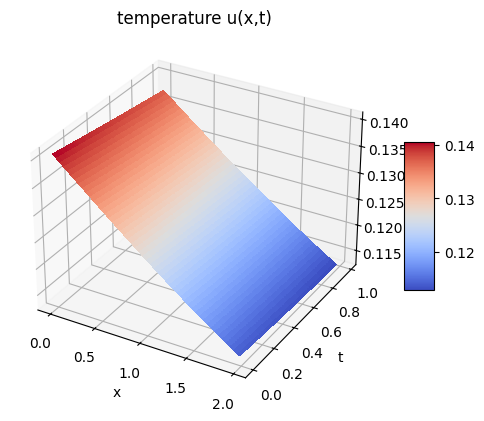

8 Training Loss: tensor(0.4742)


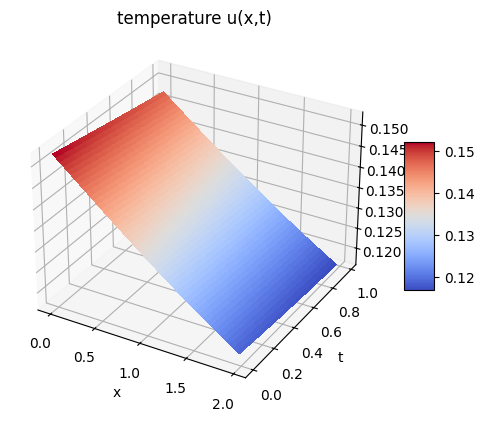

9 Training Loss: tensor(0.4591)


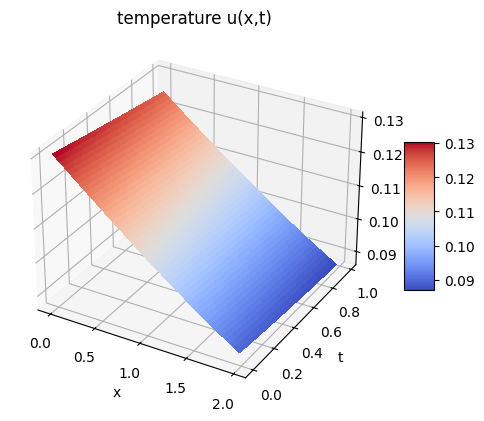

10 Training Loss: tensor(0.4187)


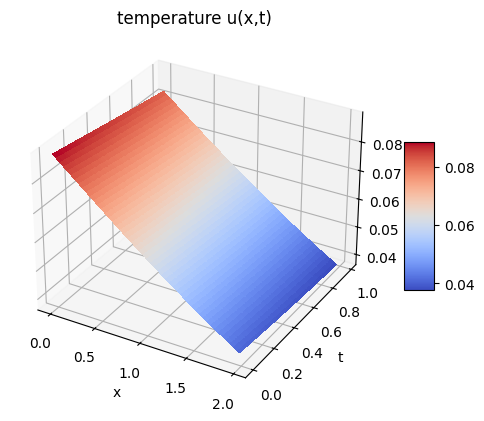

25 Training Loss: tensor(0.3847)


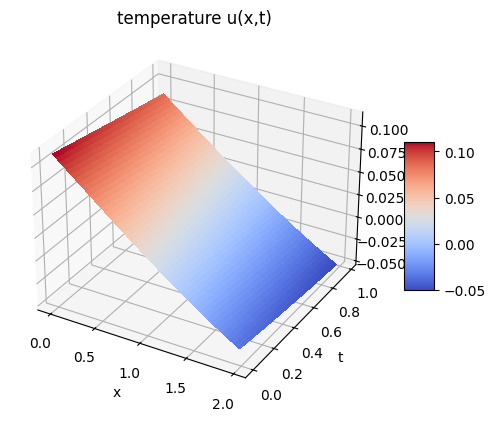

50 Training Loss: tensor(0.3567)


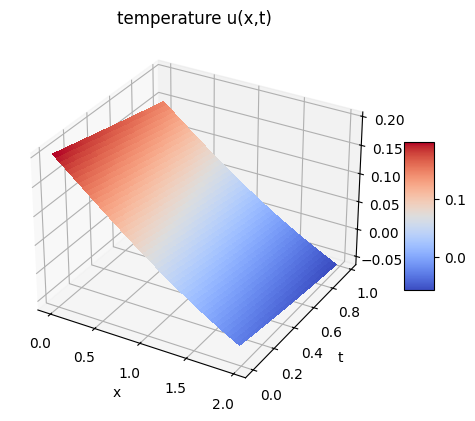

100 Training Loss: tensor(0.3181)


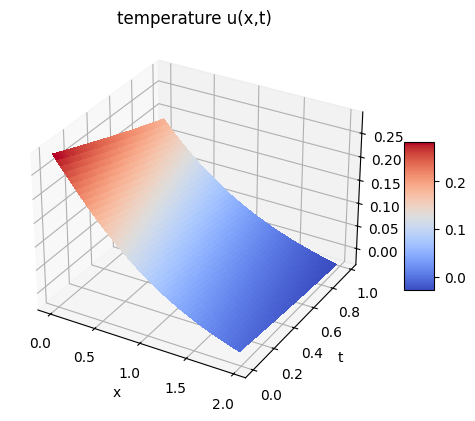

200 Training Loss: tensor(0.0644)


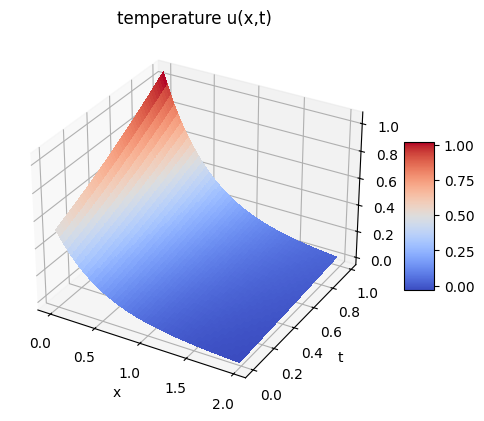

300 Training Loss: tensor(0.0601)
400 Training Loss: tensor(0.0428)
500 Training Loss: tensor(0.0232)


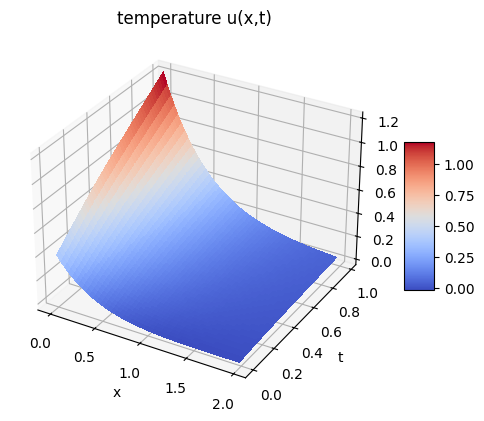

600 Training Loss: tensor(0.0217)
700 Training Loss: tensor(0.0233)
800 Training Loss: tensor(0.0169)
900 Training Loss: tensor(0.0149)
1000 Training Loss: tensor(0.0106)


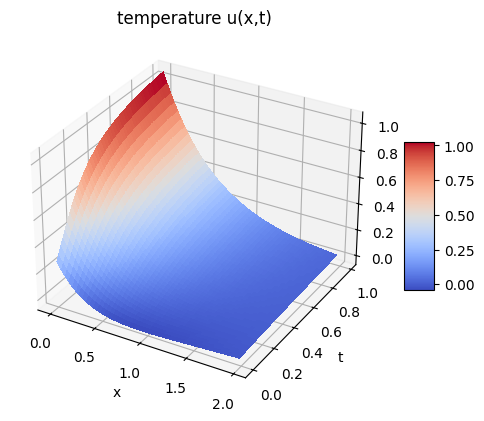

1100 Training Loss: tensor(0.0069)
1200 Training Loss: tensor(0.0104)
1300 Training Loss: tensor(0.0113)
1400 Training Loss: tensor(0.0068)
1500 Training Loss: tensor(0.0043)


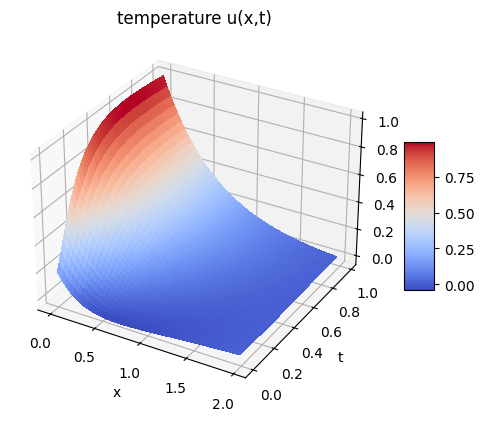

1600 Training Loss: tensor(0.0047)
1700 Training Loss: tensor(0.0058)
1800 Training Loss: tensor(0.0033)
1900 Training Loss: tensor(0.0038)
2000 Training Loss: tensor(0.0073)


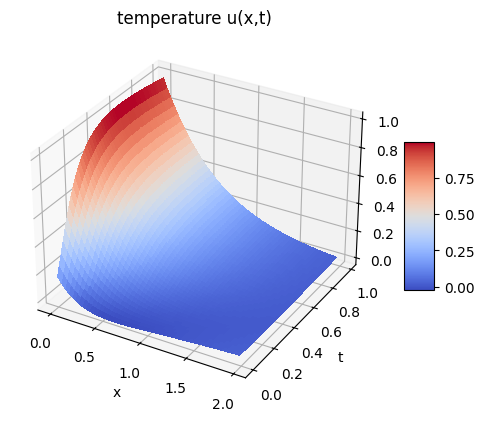

2100 Training Loss: tensor(0.0032)
2200 Training Loss: tensor(0.0018)
2300 Training Loss: tensor(0.0026)
2400 Training Loss: tensor(0.0054)
2500 Training Loss: tensor(0.0057)


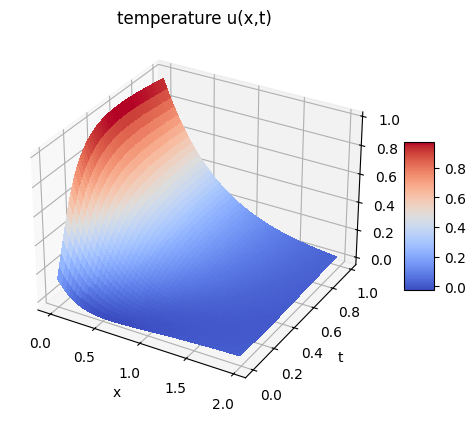

2600 Training Loss: tensor(0.0034)
2700 Training Loss: tensor(0.0021)
2800 Training Loss: tensor(0.0072)
2900 Training Loss: tensor(0.0016)
3000 Training Loss: tensor(0.0024)


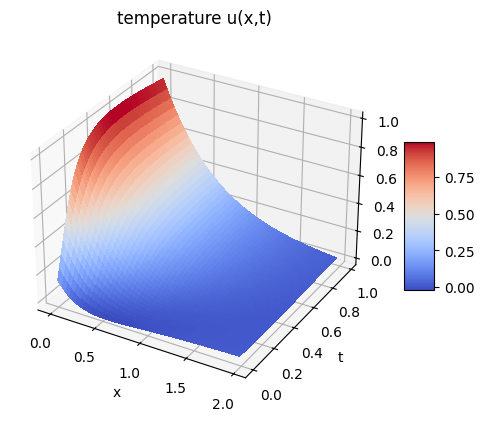

3100 Training Loss: tensor(0.0019)
3200 Training Loss: tensor(0.0020)
3300 Training Loss: tensor(0.0020)
3400 Training Loss: tensor(0.0021)
3500 Training Loss: tensor(0.0032)


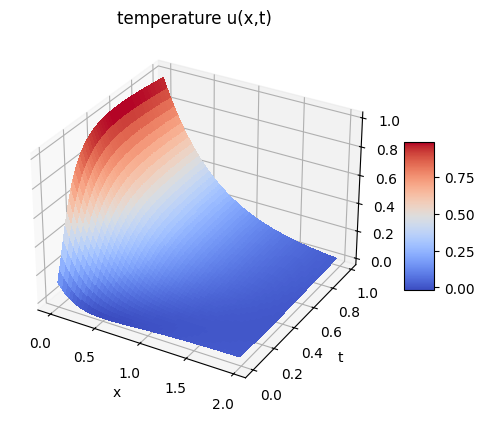

3600 Training Loss: tensor(0.0030)
3700 Training Loss: tensor(0.0033)
3800 Training Loss: tensor(0.0024)
3900 Training Loss: tensor(0.0022)
4000 Training Loss: tensor(0.0020)


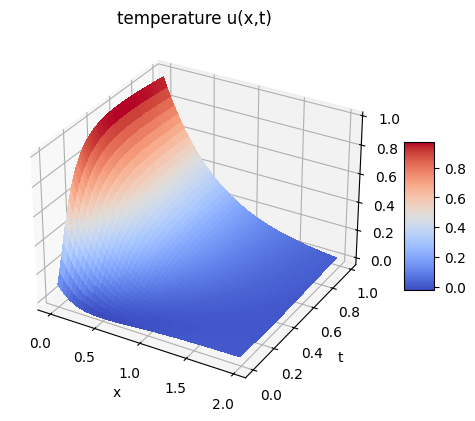

4100 Training Loss: tensor(0.0017)
4200 Training Loss: tensor(0.0008)
4300 Training Loss: tensor(0.0011)
4400 Training Loss: tensor(0.0019)
4500 Training Loss: tensor(0.0011)


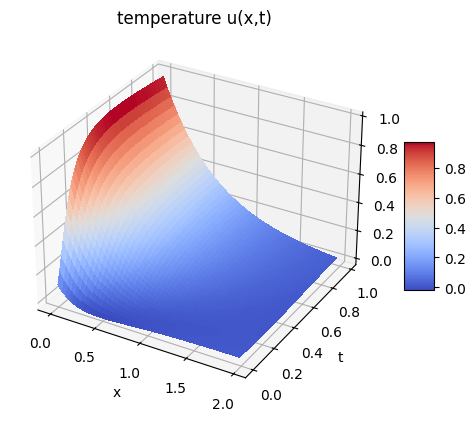

4600 Training Loss: tensor(0.0014)
4700 Training Loss: tensor(0.0013)
4800 Training Loss: tensor(0.0009)
4900 Training Loss: tensor(0.0015)


In [12]:
net = FCN().to(device)
heat_equation = forward_problem(net)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

heat_equation.solve(N_iter=5000)